In [53]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import base

import warnings
warnings.filterwarnings('ignore')

In [54]:
air_ml_df = pd.read_csv(os.path.join("weekly_air_data.csv"))
air_ml_df.head(5)

,Unnamed: 0,air_area_name,visitors,current_week
0,0,Tōkyō-to Minato-ku Shibakōen,2069,0
1,1,Tōkyō-to Minato-ku Shibakōen,2092,1
2,2,Tōkyō-to Minato-ku Shibakōen,2095,2
3,3,Tōkyō-to Minato-ku Shibakōen,1999,3
4,4,Tōkyō-to Minato-ku Shibakōen,1983,4


In [55]:
ic_air_ml_df = air_ml_df.loc[air_ml_df["visitors"]==0]
ic_air_ml_df.head(5)

remove_area = list(ic_air_ml_df["air_area_name"].unique())
remove_area

['Hokkaidō Katō-gun Motomachi',
 'Niigata-ken Kashiwazaki-shi Chūōchō',
 'Fukuoka-ken Fukuoka-shi Tenjin',
 'Tōkyō-to Meguro-ku Takaban',
 'Tōkyō-to Chiyoda-ku Kanda Jinbōchō',
 'Tōkyō-to Musashino-shi Midorichō',
 'Tōkyō-to Adachi-ku Chūōhonchō',
 'Tōkyō-to Kōtō-ku Tomioka',
 'Hokkaidō Sapporo-shi Atsubetsuchūō 1 Jō',
 'Tōkyō-to Edogawa-ku Chūō',
 'Hokkaidō Sapporo-shi Kita 24 Jōnishi',
 'Tōkyō-to Fuchū-shi Miyanishichō',
 'Ōsaka-fu Ōsaka-shi Ōhiraki',
 'Niigata-ken Niigata-shi Teraohigashi',
 'Ōsaka-fu Ōsaka-shi Nanbasennichimae',
 'Fukuoka-ken Kitakyūshū-shi Konyamachi',
 'Hyōgo-ken Amagasaki-shi Higashinanamatsuchō',
 'Tōkyō-to Musashino-shi Kichijōji Honchō',
 'Tōkyō-to Taitō-ku Asakusa',
 'Ōsaka-fu Suita-shi Izumichō',
 'Tōkyō-to Toshima-ku Sugamo',
 'Tōkyō-to Meguro-ku Jiyūgaoka',
 'Fukuoka-ken Fukuoka-shi Imaizumi',
 'Tōkyō-to Shibuya-ku Higashi',
 'Tōkyō-to Setagaya-ku Kitazawa']

In [56]:
for area in remove_area:
    air_ml_df = air_ml_df[air_ml_df.air_area_name != area]

In [57]:
true_false_df = air_ml_df.isin(remove_area)
true_false_df["air_area_name"].unique()

array([False])

In [58]:
nz_ml_df = air_ml_df
nz_ml_df = nz_ml_df.sort_values(['current_week', 'air_area_name'])
nz_ml_df.head(10)

,Unnamed: 0,air_area_name,visitors,current_week
159,159,Fukuoka-ken Fukuoka-shi Daimyō,2416,0
848,848,Fukuoka-ken Fukuoka-shi Hakata Ekimae,606,0
3021,3021,Fukuoka-ken Fukuoka-shi Momochi,445,0
689,689,Fukuoka-ken Fukuoka-shi Shiobaru,397,0
4240,4240,Fukuoka-ken Fukuoka-shi Takatori,180,0
2014,2014,Fukuoka-ken Fukuoka-shi Torikai,452,0
2915,2915,Fukuoka-ken Itoshima-shi Maebarunishi,44,0
2332,2332,Fukuoka-ken Kitakyūshū-shi None,182,0
742,742,Fukuoka-ken Kitakyūshū-shi Ōtemachi,265,0
795,795,Fukuoka-ken Kurume-shi Jōnanmachi,303,0


In [59]:
from sklearn.preprocessing import LabelEncoder

number = LabelEncoder()
nz_ml_df["air_area_name"] = number.fit_transform(nz_ml_df["air_area_name"].astype('str'))

nz_ml_df = nz_ml_df[["air_area_name","current_week","visitors"]]
nz_ml_df = nz_ml_df.reset_index()

In [60]:
class ToSupervised(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Week_Ago'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        
            
        return tmp

In [61]:
class ToSupervisedDiff(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Week_Ago_Diff_'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

In [62]:
from itertools import chain
class Kfold_time(object):
    
    def __init__(self,**options):
        
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)

        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.date_col==None )| (self.date_init==None ) | (self.date_final==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")

        for i in range(self.date_init,self.date_final):

            train = X[X[self.date_col] < i]
            val   = X[X[self.date_col] == i]

            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values

            yield X_train, X_test, y_train, y_test

    
    def split(self,X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)

In [64]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, predCol):
        """
            As a base model we assume the number of sales last week and this week are the same
            Input: 
                    predCol: l-week ago sales
        """
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y,scoring):
        
        prediction = self.predict(X)
    
        error =scoring(y, prediction)# np.sqrt(mean_squared_log_error(y, prediction))
        return error

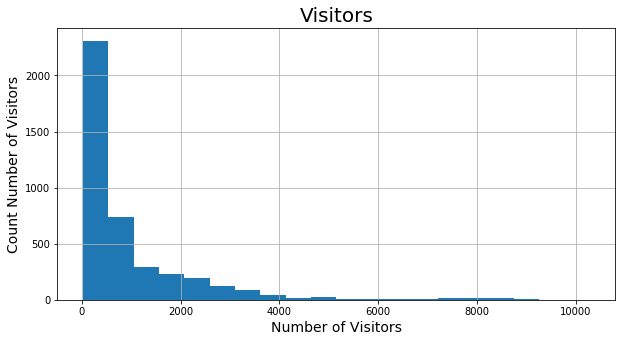

In [71]:
air_ml_df['visitors'].hist(bins=20, figsize=(10,5))
plt.xlabel('Number of Visitors',fontsize=14)
plt.ylabel('Count Number of Visitors',fontsize=14)
plt.title('Visitors',fontsize=20)
plt.show()

In [72]:
steps = [('1_step',ToSupervised('visitors','air_area_name',1)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','air_area_name',1,dropna=True))]
super_1 = Pipeline(steps).fit_transform(nz_ml_df)

KeyError: 'Column not found: 1_Week_Ago_Sales'

In [ ]:
super_1.head()

In [ ]:
kf = Kfold_time(target='visitors',date_col = 'current_week',date_init=0,date_final=40)

In [ ]:
base_model = BaseEstimator('1_Week_Ago_Sales')
errors = []
for indx,fold in enumerate(kf.split(super_1)):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test,y_test,rmsle)
    errors.append(error)
    print("Fold: {}, Error: {:.3f}".format(indx,error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))